In [285]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [293]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Читаем данные из файла со значениями пассажиропотока

In [287]:
df = pd.read_csv('/airline-passengers.csv')


In [288]:
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [289]:
df['n'] = df.index
new_df = df['Month'].str.split('-',expand=True)
new_df[1] = new_df[1].astype('int64')
new_df[0] = new_df[0].astype('int64')
df = pd.concat([df,new_df],axis=1)
df.columns=['Month','Passengers','n', 'y', 'm']
df.drop(columns='Month', inplace=True)#Отбросим первый столбец

In [291]:
data = df

In [292]:
data.shape

4

Делаем нормализацию

In [349]:
train_split = 130
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

Создаем данные для обучения

In [350]:
# список признаков, по которым будем учить
channelIndexes = [1, 2, 3]
# длина теста
valLen = 6
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 3
# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

Формируем параметры для генерации выборки

In [351]:
# шаг по данным для построения обучающих примеров
step = 1
# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10


Выделяем части на обучение и проверку

In [352]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(3)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(3)]].values
yVal = data_f.iloc[label_start:,0].values


In [353]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(129, 3)
(129,)
(8, 3)
(8,)


Посмотрим на них

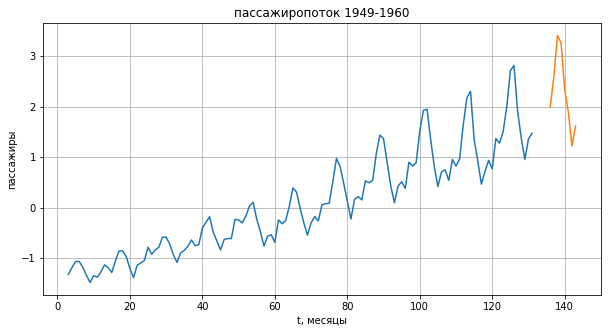

In [354]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('_______')
plt.xlabel('t, месяцы')
plt.ylabel('пассажиры')
plt.title('пассажиропоток 1949-1960')
plt.show()

Используем механизм формирования пакетов для обучения

In [355]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)


In [356]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 3)
Target shape: (32,)


In [357]:
inputs[2,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.81275558, -0.78610786, -0.75946013])>

In [358]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8461509593965585>

**сеть:  LSTM слои+Conv1D +Dense слой.**

Epoch 1/10
4/4 [==============================] - 1s 149ms/step - loss: 1.0447 - mae: 0.8538 - val_loss: 6.7377 - val_mae: 2.5298
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 0.8183 - mae: 0.7428 - val_loss: 5.7114 - val_mae: 2.3180
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6299 - mae: 0.6386 - val_loss: 4.5247 - val_mae: 2.0462
Epoch 4/10
4/4 [==============================] - 0s 16ms/step - loss: 0.4322 - mae: 0.5115 - val_loss: 3.1349 - val_mae: 1.6732
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.2412 - mae: 0.3654 - val_loss: 1.6928 - val_mae: 1.1667
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1253 - mae: 0.2677 - val_loss: 0.6611 - val_mae: 0.6120
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1382 - mae: 0.3011 - val_loss: 0.3708 - val_mae: 0.4883
Epoch 8/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1521 - mae: 0.3253 - va

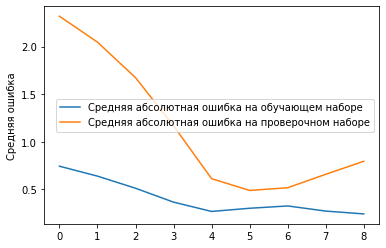

In [359]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(50, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(50, return_sequences="True"))
model.add(Conv1D(50, 3, activation="linear"))
#model.add(Conv1D(32, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [360]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
4/4 [==============================] - 0s 18ms/step - loss: 0.1127 - mae: 0.2434 - val_loss: 0.9937 - val_mae: 0.8200
Epoch 2/10
4/4 [==============================] - 0s 18ms/step - loss: 0.1080 - mae: 0.2402 - val_loss: 0.8454 - val_mae: 0.7556
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0983 - mae: 0.2311 - val_loss: 0.6491 - val_mae: 0.6537
Epoch 4/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0956 - mae: 0.2319 - val_loss: 0.5340 - val_mae: 0.5785
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0965 - mae: 0.2365 - val_loss: 0.5218 - val_mae: 0.5703
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0949 - mae: 0.2319 - val_loss: 0.5758 - val_mae: 0.6107
Epoch 7/10
4/4 [==============================] - 0s 18ms/step - loss: 0.0931 - mae: 0.2243 - val_loss: 0.6333 - val_mae: 0.6501
Epoch 8/10
4/4 [==============================] - 0s 17ms/step - loss: 0.0924 - mae: 0.2221 - val

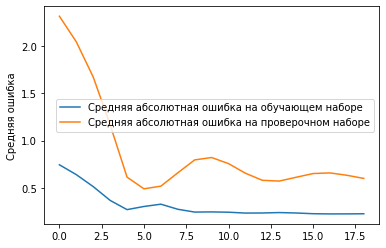

In [361]:

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [362]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

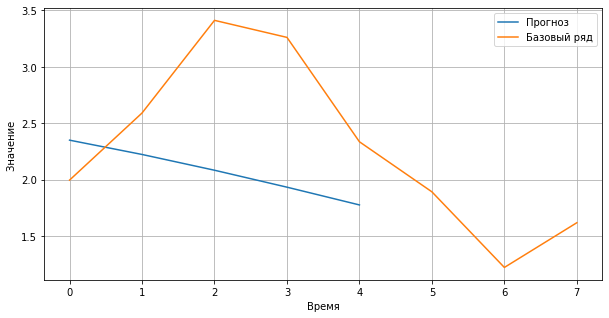

In [363]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

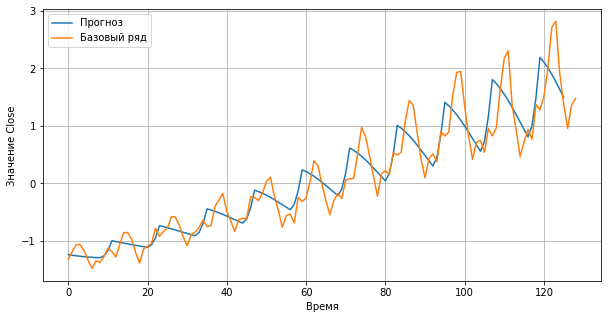

In [364]:
start = 0
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [ ]:
print(f'')

In [365]:
mean_absolute_error(yVal[:-2], predVal)

0.5985216850284119

Проверяем качество модели

In [431]:
train_split = 126
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)
channelIndexes = [1, 2, 3] # список признаков, по которым будем учить
valLen = 3 # длина теста
xLen = 3 # длина истории для работы
bias = 3 # отступ тестов от тренировок
train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [432]:
step = 1 # шаг по данным для построения обучающих примеров
past = xLen # длина прошлого
p = past
future = 1 # горизонт предсказания
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 12
epochs = 10

In [433]:
start = xLen + future
end = start + train_split-1

xTrain = train_data[[train_data.columns[i] for i in range(3)]].values
yTrain = data_f.iloc[start:end,0].values

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future

label_start = len(train_data)+bias+xLen + future

xVal = val_data.iloc[:x_end+1][[val_data.columns[i] for i in range(3)]].values
yVal = data_f.iloc[label_start:,0].values

In [434]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(125, 3)
(125,)
(12, 3)
(12,)


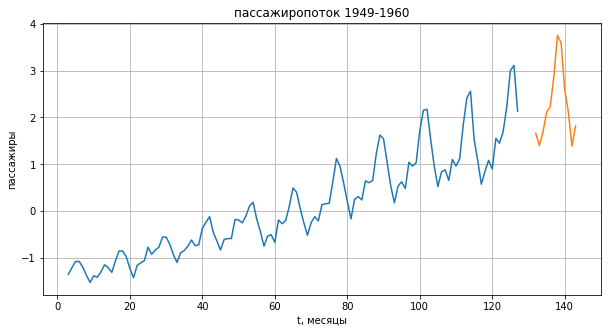

In [435]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
plt.grid('_______')
plt.xlabel('t, месяцы')
plt.ylabel('пассажиры')
plt.title('пассажиропоток 1949-1960')
plt.show()

In [436]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [437]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (12, 3, 3)
Target shape: (12,)


Epoch 1/20
11/11 [==============================] - 1s 57ms/step - loss: 0.9286 - mse: 0.9286 - val_loss: 4.7261 - val_mse: 4.7261
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 0.3798 - mse: 0.3798 - val_loss: 1.6929 - val_mse: 1.6929
Epoch 3/20
11/11 [==============================] - 0s 10ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.3882 - val_mse: 0.3882
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.1682 - mse: 0.1682 - val_loss: 0.6031 - val_mse: 0.6031
Epoch 5/20
11/11 [==============================] - 0s 9ms/step - loss: 0.1174 - mse: 0.1174 - val_loss: 0.5476 - val_mse: 0.5476
Epoch 6/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1178 - mse: 0.1178 - val_loss: 0.4261 - val_mse: 0.4261
Epoch 7/20
11/11 [==============================] - 0s 9ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.4885 - val_mse: 0.4885
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1058 - mse:

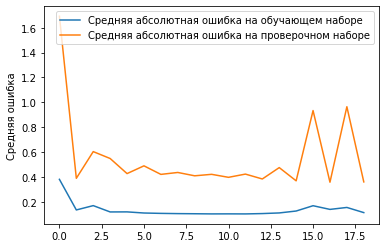

In [457]:
callback = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(50, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(50, return_sequences="True"))
model.add(Conv1D(50, 3, activation="linear"))
#model.add(Conv1D(32, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mse'])

history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mse'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [458]:
hist_val = history.history['val_mse']
hist_train = history.history['mse']

In [459]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

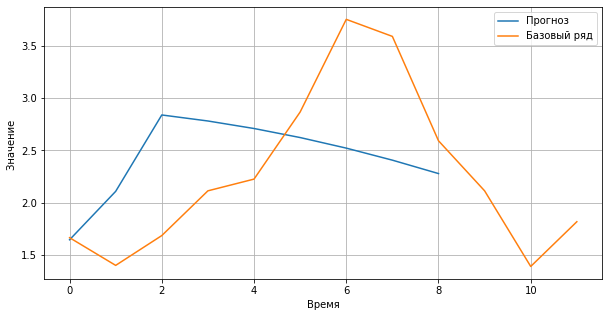

In [460]:
start = 0
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

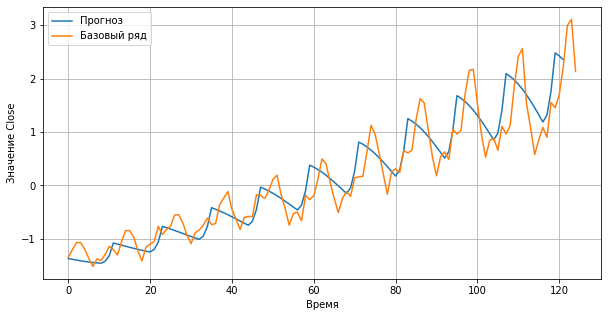

In [461]:
start = 0
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [462]:
mean_absolute_error(yVal[:-2], predVal) # уменьшили банч

0.47978801531153276

In [ ]:
#batch, но еще большую роль играет выбор функций loss и optimizer.

При уменьшении batch падает точность -

 при равном 6 - mae 0.85, 

 при 12 - 0.54, 
 
 при 10 - 0. 55

 при 18 - 0,59 
Значит этот параметр надо подбирать к конкретному случаю

при увеличении обучающей выборки точность тоже растет, но в данном случае нужно еще смотреть кратность месяцам

при batch  12 и обучающей выборке 126 - mae 0.48

добавили еще 1 слой - mae 0.500

изменили loss - mse- > mae.mae  0.589 , но график стал более сглаженым - меньше перепадов внутри года

изменили параметры модели на 
(loss="mse", optimizer="adam", metrics=['mse'])
mae - 0.47


Таким образом, получаем, что точность модели зависит от очень многих параметров, лучший результат получился на модели, которая была обучена последней